<a href="https://colab.research.google.com/github/PlaZMaD/ml_miem_2024/blob/main/Seminar_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Семинар 4. Основы статистического обучения


Использованы материала курса [Машинное обучение 1](https://www.hse.ru/edu/courses/339499745).

В этом упражнении мы изучим некоторые наборы данных, включенные в [учебник ISLR](https://hastie.su.domains/ISLR2/ISLRv2_website.pdf). Код в учебнике написан на языке R, но многие функции имеют эквивалент в Python.

In [ ]:
# let the statsmodels library to be consistent with latest pandas
!pip -q install --upgrade statsmodels

# allows us to print multiple outputs from a single Colab cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# load important libraries that we might use
import numpy as np, pandas as pd, matplotlib.pylab as plt, seaborn as sns, statsmodels.api as sm
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import r2_score

# Increase viewable area of Pandas tables, numpy arrays, plots
pd.options.display.max_rows = 15
pd.options.display.max_columns = 50
np.set_printoptions(linewidth=10000, precision=4, edgeitems=20, suppress=True)
plt.rcParams['figure.figsize'] = [16, 6]

Загрузим датасет `advertising`:

In [ ]:
csv_url = 'https://raw.githubusercontent.com/hse-ppmm/Seminars/main/advertising.csv' # assign file path to a variable
colNames = ['TV', 'radio', 'newspaper', 'sales']
df = pd.read_csv(csv_url)#[colNames]   # load dataframe and slice (filter) columns
df.head()

In [ ]:
df.tail(10)

In [ ]:
df.sample(10)

In [ ]:
df.TV

In [ ]:
df['TV']

## Типы данных

Мы переходим к исследованию набора данных. Функция `df.info()` - это быстрый способ обнаружить возможные распространённые проблемы с данными.

**Почему:** Мы всегда должны быть знакомы со структурами данных наших данных. Неожиданные типы данных могут испортить производительность модели. Например, числа, загруженные как строки, потеряют свое упорядочение и связанные с ними алгебраические операции.

**Вывод:** Результаты `df.info()` ниже показывают.
* отсутствие пропущенных значений => не является проблемой для числовых вычислений
* все переменные с плавающими значениями => не проблема для числовых вычислений
* 6.4 КБ данных в памяти => не проблема для ресурсов оперативной памяти
* 4 переменные и 200 значений в каждом столбце, как и ожидалось

In [ ]:
df.info()

## Scatterplot

Мы можем строить графики непосредственно из объектов `DataFrame` без явного вызова библиотеки `matplotlib`. Визуализации являются эффективными инструментами подведения итогов, но у них есть свои ограничения, преимущества и недостатки. Освоение этих техник и развитие интуиции требует времени и усилий.

**Почему**: Мы хотим глубже изучить взаимосвязь между `radio` и `newspaper`. Мы можем сделать это с помощью `scatterplot`.

**Вывод:**
* Сильная связь между двумя переменными будет выражена в определенной форме. Случайно разбросанные точки говорят об отсутствии взаимосвязи. Линейная связь выражалась бы в виде вытянутого облака вдоль какой-то негоризонтальной линии. Здесь мы этого не видим.
* Однако мы наблюдаем некоторый перекос точек данных в правую область графика.
* В целом, коллинеарность этих двух переменных не должна вызывать беспокойства при прогнозировании продаж, но крайние 4 наблюдения могут быть проблематичными для моделей, использующих евклидовы метрики расстояния, поскольку значения координат этих точек будут доминировать при обучении коэффициентов модели.
* Обратите внимание, что 3 точки в правом верхнем углу имеют обе сильно выделяющиеся от остальных точек координаты; и одна точка (в правой нижней области) имеет только одну такую отличающуюся координату.

In [ ]:
# note the semicolon, which suppresses extraneous output
df.plot.scatter('TV', 'sales', grid=True, title='Scatter plot of Radio and TV');

## Корреляция

DataFrames могут позволить нам вычислить различные статистики за один вызов своего метода.

**Почему:** Мы хотели бы еще больше обобщить взаимосвязь с помощью коэффициента корреляции Пирсона. Примечательно, что он измеряет только линейную связь между парами значений координат.

**Понятие:**
* Диагональные элементы - это корреляции переменных с самими собой, поэтому все они единицы. Внедиагональные значения указывают на выборочные корреляции между каждой парой переменных. В частности, `0.35` между `newspaper` и `radio`. Это не очень высокий показатель, но он указывает на некоторую линейную связь, что согласуется с нашими наблюдениями на диаграмме рассеяния выше.
* Итак, небольшая коллинеарность присутствует, но пока не является серьезной проблемой.

In [ ]:
df.corr()

In [ ]:
plt.hist2d(df.radio, df.TV)
plt.xlabel('radio')
plt.ylabel('TV')

In [ ]:
print(np.mean(df.TV))

print(np.std(df.TV))

In [ ]:
df.describe(percentiles=[.5])

## Базовая статистика

На самом деле, есть ещё один простой способ получить основную статистику для наших переменных. При этом мы должны стараться заметить 4 свойства каждой переменной:
1. **Центральность** говорит нам о местоположении каждой переменной. Типичными показателями являются среднее, медиана, мода, усеченное среднее и т.д. Если среднее $\approx$ медиана, то распределение симметрично.
2. **Дисперсия** говорит нам о дисперсии значений. Типичными показателями являются дисперсия, стандартное отклонение, диапазон, интерквартильный размах (IQR).
3. **Перекошенность** показывает, является ли распределение значений перекошенным влево/вправо или симметричным.
4. **Куртозис** говорит нам, присутствуют ли в данных экстремальные значения. Это может быть проблематично для многих моделей, которые используют евклидову метрику для измерения важности сходства между переменными. Экстремальные значения потенциально могут быть [**влиятельными**](https://en.wikipedia.org/wiki/Influential_observation) (сильно влияющими на наклон регрессионных моделей).

**Зачем:** Мы хотим быстро оценить любые аномалии в распределениях переменных.

**Вывод:** Из основных статистических данных ниже мы узнаем, что.
* **Центральность**:
  * среднее значение `TV` и медиана близки ($147\approx 150$, учитывая `std` 86$). Симметричное распределение может быть смоделировано с помощью нормальной плотности (если это необходимо). Итак, отметим эту симметрию. Отметим, что бюджет `ТВ` в ~6 раз больше, чем у `radio` или `newspaper`.
  * среднее и медиана `radio` также похожи, в свете `std` ~15
  * ``newspaper`` имеет небольшой перекос вправо, ее среднее значение больше медианы. Это предполагает правый перекос или большой правый хвост (некоторые экстремальные положительные значения). Действительно, мы отмечаем максимальное значение 114, что в ~4.5 раза больше медианы, в то время как минимальное значение составляет всего 0.3. Экстремальные значения могут повлиять на некоторые модели, если соответствующие значения ответов не являются экстремальными.
* ... мы переходим к наблюдению и оценке каждого момента каждой переменной

In [ ]:
plt.hist(df.sales)

In [ ]:
df.describe().T

## Взаимосвязи

**Зачем:** Приведенные выше статистические данные дают представление о взаимосвязях между нашими переменными. Мы можем построить быструю визуализацию для оценки любой потенциально сильной взаимосвязи, которая может либо помочь, либо навредить модели. Взаимосвязи с откликом полезны, в то время как взаимосвязи между признаками проблематичны. Последние вносят избыточность в набор данных. Это может привести к нестабильности и затруднить интерпретацию обученных параметров регрессии.

**Вывод:**

Графики
* Взаимосвязи между характеристиками не очевидны. В частности, `TV` и `radio` выглядят как чистый шум от равномерного распределения в обеих координатах.
* Сильная связь отмечается между `TV` и `sales`.
* `radio` имеет более слабую объяснительную силу в `sales`
* `newspaper` практически не связана с `sales`, но имеет некоторую связь с `radio`.
* Мы также должны рассмотреть некоторые преобразования признаков, которые усилят их объясняющую способность `sales`, по крайней мере, в линейной модели.

Гистограммы
* `TV` и `radio` выглядят равномерно распределенными
* `newspaper`, похоже, следует некоторому [треугольному распределению](https://en.wikipedia.org/wiki/Triangular_distribution). Оно также напоминает экспоненциальное. В меньшей степени это похоже на [экспоненциальное распределение](https://en.wikipedia.org/wiki/Exponential_distribution). Обратите внимание на частоту правого хвоста при значении около 100. Мы наблюдали это и в сводке основных статистических данных.
* `sales` также похожа на треугольную и, в некоторой степени, на гауссову. Однако она не является полностью симметричной, так как мы наблюдаем правый перекос распределения. Кроме того, гауссовская случайная величина имеет [support](https://en.wikipedia.org/wiki/Support_(математика)) (где плотность ненулевая) $\mathbb{R}$, в то время как переменная `sales` не может быть отрицательной. Поэтому поддержка продаж равна $\mathbb{R}_{\ge0}$.


In [ ]:
ax = sns.pairplot(df, plot_kws=dict(linewidth=0, s=3));
ax.fig.suptitle("Pairplot of variables in Advertising dataset", y=1);
ax.fig.set_size_inches(10,4);   # control the size of your visualiztaions

## Корреляционный график

Обычно мы избегаем избыточности, когда это возможно. Здесь для демонстрации альтернативного метода мы используем библиотеку seaborn для построения корреляционной матрицы. Примечательно, что это дает количественную оценку качественным изображениям, которые мы видели выше.

**Почему:** Мы хотим оценить линейные отношения между всеми переменными. Это позволяет выявить важные полезные (коррелирующие) и проблемные признаки.

**Вывод:**
* Корреляция 0.78 между `TV` и `sales` должна сильно помочь линейной модели.
* `radio` также имеет сильную корреляцию с `sales` и некоррелирует с `TV`, следовательно, `radio` должно внести дополнительный вклад в производительность модели.
* `newspaper` имеет наименьшую корреляцию с `sales`, но также слабо коррелирует с другими характеристиками.
* Мы не наблюдаем сильных корреляций между характеристиками.

In [ ]:
plt.rcParams['figure.figsize'] = [6, 3];  # control the size of your visualiztaions
sns.heatmap(df.corr(), annot = True);     # note the semicolon, which suppresses extraneous output

## Базовая модель, v0 (версия 0)

Теперь, когда некоторые исследовательские анализы данных (EDA) завершены, давайте проверим одну модель. Пропущенных значений не отмечено, и все переменные являются числовыми. Итак, мы можем применить линейную регрессию непосредственно к данному набору данных `Advertising`.

### Обучение и тестирование наблюдений

Сначала нам нужно (*случайно!*) разделить наблюдения на обучающий и тестовый наборы. Затем обучить модель на обучающих наблюдениях и оценить на тестовых наблюдениях. Для воспроизводимости мы всегда засеваем наши модели любым числом (ноль подходит для любого). Для вычисления **вневыборочной** (тестовой) силы модели мы берем 20% наблюдений.

ВАЖНО: Очень важно убедиться, что переменная отклика не является частью входных данных. Такая **утечка** является типичной ошибкой. Если результаты вашей модели слишком хороши, чтобы быть правдой, подозревайте утечку.

У нас есть:
* `tX` - обучающие признаки
* `tY` - соответствующие обучающие ответы
* `vX` - признаки валидации (тестирования)
* `vY` - соответствующие валидационные (тестовые) ответы.

**Вывод:** Наконец, мы делаем проверку, что мы нигде не ошиблись.
* у нас есть 160 обучающих ответов и 160 обучающих наблюдений
* 40 тестовых ответов и 40 тестовых наблюдений.
* 3 функции входят в модель во время обучения
* 3 функции входят в модель во время тестирования.

In [ ]:
from statsmodels.regression.linear_model import OLS
?OLS

In [ ]:
from sklearn.model_selection import train_test_split as tts

tX, vX, tY, vY = tts(df.drop('sales', axis=1), df['sales'], test_size = 0.2, random_state=0)
print(f'Sanity check for dimensions of variables: {tX.shape, vX.shape, tY.shape, vY.shape}')

**Зачем:** Быстрое создание прототипа позволит получить немедленную обратную связь о наших минимальных усилиях. Мы будем использовать результаты модели v0 в качестве эталона в следующей итерации. Если модель v1 превзойдет v0, мы оставим v1. В противном случае мы попробуем различные изменения.

**Вывод:**
* $R^2_{\text{OOS}}=0.98$ очень высок, но мы наблюдали сильную корреляцию между входными данными и ответом и низкую корреляцию между входными данными. Таким образом, этот результат не является необычным, и утечка не вызывает беспокойства.
* В этой базовой модели в таблице коэффициентов отсутствует член смещения (перехвата). Возможно, его добавление в модель v1 улучшит $R^2_{\text{OOS}}$.
* `TV` и `radio` имеют p-значения ниже, чем заданный нами уровень значимости, $\alpha=0.01$. Мы считаем их значимыми для данной модели. С точки зрения статистики, в каждом случае мы отвергаем нулевые гипотезы о том, что их коэффициенты равны нулю. То есть $H_0:\beta_{\text{TV}}=0$, $H_0:\beta_{\text{radio}}=0$ отвергаются в пользу соответствующих альтернативных гипотез.
* Однако, мы не можем отвергнуть $H_0:\beta_{\text{newsp
aper}}=0$ при $\alpha=0.01$, потому что p-значение 0.064 превышает указанную $\alpha$.
  * Прежде чем отбросить переменную `newspaper` как незначимую, давайте добавим член смещения и заново оценим эффективность и значимость переменной.
* Коэффициенты говорят нам о том, что при прочих равных условиях расходы в размере 1 доллар на рекламу по телевидению должны увеличить продажи на 5 центов, а расходы в размере 1 доллар на рекламу по радио должны увеличить продажи на 23 цента.

$f(x) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3$

In [ ]:
fmdl = OLS(tY, tX).fit()    # training on train observations
#fmdl = mdl.fit()
print(fmdl.summary(title='Baseline model for Advertising dataset', alpha=.01))
pY = fmdl.predict(vX)   # predicted values on the testing set
print(f'Out of sample R^2 is {r2_score(vY,pY):.2f}')

In [ ]:
ax = sns.pairplot(df, plot_kws=dict(linewidth=0, s=3));
ax.fig.suptitle("Pairplot of variables in Advertising dataset", y=1);
ax.fig.set_size_inches(10,4);   # control the size of your visualiztaions

In [ ]:
from sklearn.linear_model import LinearRegression

fdml = LinearRegression()
fdml.fit(tX, tY)

In [ ]:
print(list(tY))

In [ ]:
linear_estimates = fdml.predict(vX)

In [ ]:
linear_estimates

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
np.sqrt(mean_squared_error(vY, linear_estimates))

In [ ]:
mean_absolute_error(vY, linear_estimates)

In [ ]:
linear_estimates_train = fdml.predict(tX)
np.sqrt(mean_squared_error(tY, linear_estimates_train))

In [ ]:
df.describe()

Метод наименьших квадратов
==========================

In [ ]:
x = np.linspace(0,10, 50)
a, b = 2.5, 5.25
y = a * x + b + np.random.normal(0.0, 2.0, x.shape)

plt.scatter(x,y)

In [ ]:
import numpy.linalg

A = np.vstack([x, np.ones_like(x)]).T
theta = np.linalg.solve(A.T.dot(A), A.T.dot(y))
res = np.linalg.norm(A.dot(theta)-y)**2
theta_err = np.linalg.inv(A.T.dot(A)) * res / (x.shape[0] - theta.shape[0])
predicted = A.dot(theta)
plt.scatter(x,y)
plt.plot(x, predicted, color='red')
a, b = 2.5, 5.25
y = a * x + b
plt.plot(x, y, c='g')
print("a = {} +- {}".format(theta[0], np.sqrt(theta_err[0,0])))
print("b = {} +- {}".format(theta[1], np.sqrt(theta_err[1,1])))

In [ ]:
theta, res, _, _ = numpy.linalg.lstsq(A, y, rcond=None)
print(theta)

In [ ]:
import scipy
import scipy.linalg

theta, res, _, _ = scipy.linalg.lstsq(A, y)
print(theta)

In [ ]:
import sklearn
import sklearn.linear_model

r = sklearn.linear_model.LinearRegression()
r.fit(x.reshape(-1,1), y.reshape(-1,1))
predicted = r.predict(x.reshape(-1,1))
plt.scatter(x,y)
plt.plot(x, predicted, color='red')
print(np.hstack([r.coef_,[r.intercept_,]]))

In [ ]:
import statsmodels.api as sm

mod = sm.OLS(y, sm.add_constant(x))
res = mod.fit()
print(res.summary())

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.linear_model
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error

names = ("id", "n", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe", "Type")
data = pd.read_csv('https://raw.githubusercontent.com/hse-ppmm/Seminars/main/glass.csv', header=None, names=names, index_col=0)

x = np.asarray(data.iloc[:, 1:9])
y = np.asarray(data.iloc[:, [0]]).reshape(-1,1)

x_train, x_test, y_train, y_test = tts(x, y, random_state=42)
print(x_train.shape, x_test.shape)

r = sklearn.linear_model.LinearRegression()
r.fit(x_train, y_train)
mse_test = np.sqrt(mean_squared_error(y_test, r.predict(x_test)))

print(mse_test, np.mean(y))

plt.scatter(y_test, r.predict(x_test))
plt.xlabel("True")
plt.ylabel("Predicted")
_ = plt.axis('equal')

### Представление о плохо обусловленных и некорректных задачах

$$\alpha x^2 + \beta y^2 = 1$$

In [ ]:
from matplotlib.patches import Ellipse

def fit_ellipse(x, plot = False):
    X = x**2
    cond = numpy.linalg.cond(X)

    r = sklearn.linear_model.LinearRegression(fit_intercept=False)
    r.fit(X, np.ones((x.shape[0],1)))

    theta = np.asarray(r.coef_).reshape(-1)
    width, height = 2 * numpy.power(theta, np.full_like(theta, -0.5), out=np.full_like(theta, np.nan), where=theta>0)

    if plot:
        ellipse = Ellipse((0, 0), width=width, height=height, fill=False, edgecolor='red')
        plt.scatter(*x.T)
        plt.xlim(-2.5,2.5)
        plt.ylim(-2.5,2.5)
        plt.axis('equal')
        ax = plt.gca()
        ax.add_patch(ellipse)

    return width, height, cond

def generate_ellipse(phi, width, height, size):
    x = np.vstack([width / 2 * np.cos(phi), height / 2 * np.sin(phi)]).T
    X = x + np.random.normal(0.0, 0.0125, (size,*x.shape))
    return X


In [ ]:
numpy.random.seed(42)

width = 2.0
height = 4.0

lim = 7.5 / 180.0 * np.pi
phi = np.linspace(-lim,lim,4)
X = generate_ellipse(phi, width, height, 1000)

fit_ellipse(X[1], True)
fit_ellipse(X[3], True)

r = np.array([fit_ellipse(X[i]) for i in range(X.shape[0])])
print(np.nanmean(r, axis=0))
print(np.nanstd(r, axis=0))

In [ ]:
out= generate_ellipse(phi, width, height, 1000)
print(out[0])

In [ ]:
lim = 7.5 / 180.0 * np.pi
phi = np.linspace(-lim,lim,4)
phi = np.concatenate([phi, [1.5,]])
X = generate_ellipse(phi, width, height, 1000)

fit_ellipse(X[1], True)
fit_ellipse(X[3], True)

r = np.array([fit_ellipse(X[i]) for i in range(X.shape[0])])
print(np.nanmean(r, axis=0))
print(np.nanstd(r, axis=0))

### Представление о регуляризации

Пусть нам кто-то сказал, что искомый эллипс очень похож на единичный круг:

$$\Delta \alpha x^2 + \Delta \beta y^2 = 1 - x^2 - y^2,$$

тогда $\Delta \alpha^2 + \Delta \beta^2 \rightarrow 0$.

In [ ]:
def fit_ellipse2(x, alpha, plot = False):
    X = x**2
    cond = numpy.linalg.cond(X)
    y = (1.0 - np.sum(x**2, axis=1)).reshape(-1)

    r = sklearn.linear_model.Ridge(fit_intercept=False, alpha=alpha)
    r.fit(X, y)

    theta = np.asarray(r.coef_).reshape(-1)
    width, height = 2 * numpy.power(theta + 1.0, np.full_like(theta, -0.5), out=np.full_like(theta, np.nan), where=theta>-1.0)

    if plot:
        ellipse = Ellipse((0, 0), width=width, height=height, fill=False, edgecolor='red')
        plt.scatter(*x.T)
        plt.xlim(-2.5,2.5)
        plt.ylim(-2.5,2.5)
        plt.axis('equal')
        ax = plt.gca()
        ax.add_patch(ellipse)

    return width, height, cond

In [ ]:
lim = 7.5 / 180.0 * np.pi
phi = np.linspace(-lim,lim,4)
X = generate_ellipse(phi, width, height, 1000)
alpha = np.geomspace(1e-6, 1e+3, 10)

for x in alpha:
    r = np.array([fit_ellipse2(X[i], x) for i in range(X.shape[0])])
    print("alpha = {}".format(x))
    print(np.nanmean(r, axis=0))
    print(np.nanstd(r, axis=0))
    print()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics
import pandas as pd

names = ["length", "width", "size", "conc", "conc1", "asym", "m3long", "m3trans", "alpha", "dist", "class"]
data = pd.read_csv('https://raw.githubusercontent.com/hse-ppmm/Seminars/main/magic04.csv', names=names)

x = np.asarray(data.iloc[:, :-1])
y = np.asarray(data.iloc[:, [-1]])

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

c = LogisticRegression(random_state=42, solver="newton-cg")
c.fit(x_train, y_train.reshape(-1))

score_train = c.score(x_train, y_train)
score_test  = c.score(x_test, y_test)
print(score_train, score_test)

y_test_predicted = c.predict(x_test)
y_test_scores =  c.decision_function(x_test)

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_test_predicted)

fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_test_scores, pos_label=c.classes_[-1])
auc = sklearn.metrics.roc_auc_score(y_test, y_test_scores)

plt.plot(fpr, tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
print(auc)

Метод максимального правдоподобия
------------------------------------------------------------

In [ ]:
numpy.random.seed(42)
x = numpy.random.normal(1.5, 0.25, 1000)

mu_estimate = x.sum() / x.shape[0]
sigma2_estimate = ((x - mu_estimate)**2).sum() / x.shape[0]

mu_estimate, np.sqrt(sigma2_estimate)

In [ ]:
numpy.random.seed(42)
x = numpy.random.poisson(2.45, 1000)

lambda_estimate = x.sum() / x.shape[0]

lambda_estimate

In [ ]:
numpy.random.seed(42)
x = np.random.lognormal(1.5, 0.25, 1000)

mu_estimate = np.sum(np.log(x)) / x.shape[0]
sigma2_estimate = np.sum((np.log(x) - mu_estimate)**2) / x.shape[0]

mu_estimate, np.sqrt(sigma2_estimate)

In [ ]:
plt.hist(x)

In [ ]:
numpy.random.seed(42)
x = np.random.multivariate_normal([0.0, 0.0], [[1.0, 0.75],[0.75, 1.0]], 1000)
plt.plot(*x.T,'*')

mu_estimate = np.sum(x, axis=0) / x.shape[0]
dx = x - mu_estimate
sigma_estimate = np.tensordot(dx, dx, [0, 0]) / x.shape[0]

mu_estimate, sigma_estimate

### Линейные модели авторегрессии скользящего среднего

In [ ]:
import statsmodels.api as sm
import pandas as pd
from statsmodels import tsa
from statsmodels.tsa.statespace import sarimax
from statsmodels.graphics import tsaplots
from statsmodels.graphics import gofplots
from scipy.stats import boxcox

data = pd.read_csv('https://raw.githubusercontent.com/hse-ppmm/Seminars/main/sunspots.csv')
x = np.asarray(data['YEAR']).reshape(-1,1)
y = np.asarray(data['SUNACTIVITY']).reshape(-1,1)

plt.plot(x, y)
plt.xlabel("Year")
plt.ylabel("Activity index")
plt.title("Solar activity")
plt.tight_layout()

In [ ]:
plt.figure()
gofplots.qqplot(y.reshape(-1), fit=True, line='45')
plt.axis('equal')

plt.figure()
y_log = boxcox(y.reshape(-1)+1, 0)
gofplots.qqplot(y_log.reshape(-1), fit=True, line='45')
_ = plt.axis('equal')

plt.figure()
y_1 = boxcox(y.reshape(-1)+1, 0.5)
gofplots.qqplot(y_1.reshape(-1), fit=True, line='45')
_ = plt.axis('equal')

In [ ]:
tsaplots.plot_acf(y_log, lags=np.arange(50))
_ = tsaplots.plot_pacf(y_log, lags=np.arange(50))

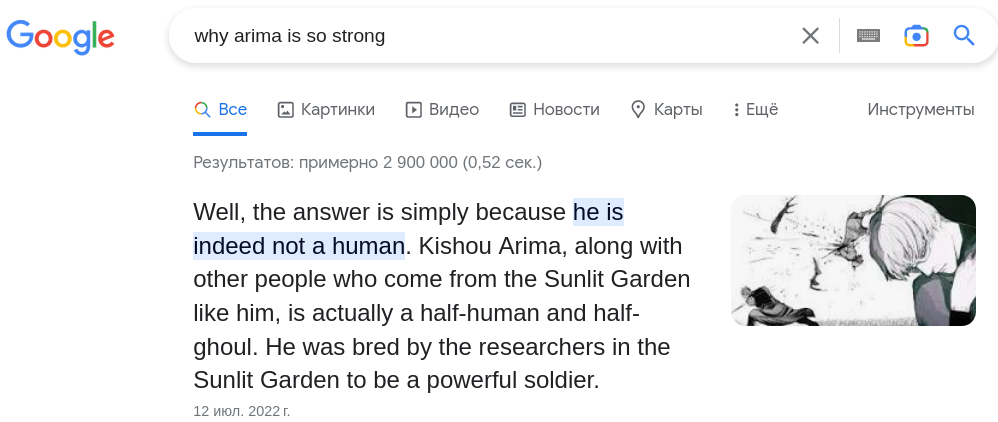

In [ ]:
arma_mod20 = sm.tsa.ARIMA(y_log, order=(2,0,0)).fit()
print(arma_mod20.summary())

arma_mod30 = sm.tsa.ARIMA(y_log, order=(3,0,0)).fit()
print(arma_mod30.summary())

# arma_mods11 = sm.tsa.ARIMA(y_log, order=(3,0,0), seasonal_order=(1,0,0,11)).fit()
# print(arma_mods11.summary())

In [ ]:
plt.figure()
tsaplots.plot_acf(arma_mod20.resid, lags=np.arange(50))

plt.figure()
_ = tsaplots.plot_acf(arma_mod30.resid, lags=np.arange(50))

# plt.figure()
# _ = tsaplots.plot_acf(arma_mods11.resid, lags=np.arange(50))

In [ ]:
n_forecast = 40
x_pred = np.arange(x[-1], x[-1] + n_forecast)
y_pred_20 = arma_mod20.predict(len(x), len(x) + n_forecast - 1)
# y_pred_s = arma_mods11.predict(len(x), len(x) + n_forecast - 1)

plt.plot(x, y_log)
plt.plot(x_pred, y_pred_20)
# plt.plot(x_pred, y_pred_s)
plt.xlabel("Year")
plt.ylabel("Activity index")
plt.title("Solar activity")
plt.tight_layout()
plt.show()

# Градиентный спуск

([источник](https://github.com/mravanba/comp551-notebooks))

Чтобы подогнать нашу модель $f_w$ к данным $\mathcal{D} = \{x^{(1)}, \ldots, x^{(N)}\}$, мы максимизируем **логарифм условного правдоподобия**:

$$
\ell(w; \mathcal{D}) = \sum_n \log \mathrm{Bernoulli}(y^{(n)} | \sigma({x^{(n)}}^\top w)) = \sum_n y^{(n)} \log \sigma({x^{(n)}}^\top w)) + (1-y^{(n)}) \log (1-\sigma({x^{(n)}}^\top w)))
$$

Подставив определение логистической функции в уравнение выше, и минимизируя **отрицательное** логарифмическое правдоподобие, которое называется **целевой функцией** (*cost function*), мы получаем

$$
J(w) = \sum_n y^{(n)} \log(1+e^{-x w^\top}) + (1-y^{(n)}) \log(1+e^{x w^\top})
$$

На практике мы используем среднее значение вместо суммы по наблюдениям.

In [ ]:
def cost_fn(x, y, w):
    N, D = x.shape
    z = np.dot(x, w)
    J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))
    return J

Для минимизации целевой функции мы используем градиентный спуск: начинаем с некоторого начального задания параметров $w$ и на каждой итерации делаем небольшой шаг в направлении, противоположном *градиенту*. Градиент целевой функции приведенной выше:

$$
\frac{\partial}{\partial w_d} J(w) =\sum_n - y^{(n)} x^{(n)}_d \frac{e^{-w^\top x^{(n)}}}{1 + e^{-w^\top x^{(n)}}} +x^{(n)}_d (1- y^{(n)}) \frac{e^{w^\top x^{(n)}}}{1 + e^{w^\top x^{(n)}}} = \sum_n - x^{(n)}_d y^{(n)} (1-\hat{y}^{(n)})+ x^{(n)}_d (1- y^{(n)}) \hat{y}^{(n)} = x^{(n)}_d (\hat{y}^{(n)} - y^{(n)})
$$
Поскольку на практике мы делим стоимость на $N$, мы должны сделать то же самое для градиента; см. реализацию ниже.

In [ ]:
def gradient(self, x, y):
    N,D = x.shape
    yh = logistic(np.dot(x, self.w))
    grad = np.dot(x.T, yh - y)/N
    return grad

Здесь функция `fit` реализует градиентный спуск.

In [ ]:
logistic = lambda z: 1./ (1 + np.exp(-z))       #logistic function
z = np.linspace(-10,10,100)

class LogisticRegression:

    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iters = max_iters
        self.verbose = verbose

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf
        t = 0
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g
            t += 1

        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self

    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))
        return yh

LogisticRegression.gradient = gradient

Возьмём синтетический пример:

In [ ]:
N = 50
x = np.linspace(-5,5, N)
y = ( x < 2).astype(int)
model = LogisticRegression(verbose=True, )
yh = model.fit(x,y).predict(x)
plt.plot(x, y, '.', label='dataset')
plt.plot(x, yh, 'g', alpha=.5, label='predictions')
plt.xlabel('x')
plt.ylabel(r'$y$')
plt.legend()
plt.show()

Видим, что модель успешно описывает обучающие данные. Если запустить оптимизацию достаточно долго, то веса вырастут (по абсолютной величине) настолько, что предсказанные вероятности для точек данных вблизи границы(x=2) будут близки к нулю и единице.

Построим график целевой функции для логистической регрессии в зависимости от параметров модели (весов) и покажем соответствие между различными весами. Функция `plot_contour` - вспомогательная функция, которую мы использовали для построения целевой функции для линейной регрессии.

In [ ]:
import itertools
def plot_contour(f, x1bound, x2bound, resolution, ax):
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    xg, yg = np.meshgrid(x1range, x2range)
    zg = np.zeros_like(xg)
    for i,j in itertools.product(range(resolution), range(resolution)):
        zg[i,j] = f([xg[i,j], yg[i,j]])
    ax.contour(xg, yg, zg, 100)
    return ax

In [ ]:
class GradientDescent:
    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8, record_history=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        if record_history:
            self.w_history = []                 # записываем историю весов для визуализации

    def run(self, gradient_fn, x, y, w):
        grad = np.inf
        t = 1
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            grad = gradient_fn(x, y, w)               # градиент с текущими весами
            w = w - self.learning_rate * grad         # обновление весов
            if self.record_history:
                self.w_history.append(w)
            t += 1
        return w

Обратите внимание, что в приведенной выше реализации мы добавили возможность записи истории параметров модели во время градиентного спуска для визуализации. Давайте переделаем класс `LinearRegression` для использования оптимизатора.

In [ ]:
class LinearRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass

    def fit(self, x, y, optimizer):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        def gradient(x, y, w):                          # функция градиента
            yh =  x @ w
            N, D = x.shape
            grad = .2*np.dot(yh - y, x)/N
            return grad
        w0 = np.zeros(D)                                # начинаем с нулевыми весами
        self.w = optimizer.run(gradient, x, y, w0)      # нахождение оптимальных весов
        return self

    def predict(self, x):
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w
        return yh

In [ ]:
N = 100
x = np.random.rand(N) * 10
y = -4*x + 10 + 2*np.random.randn(N)
optimizer = GradientDescent(learning_rate=.05, max_iters=500, record_history=True)
model = LinearRegression()
model.fit(x,y, optimizer)
plt.plot(x, y, '.')
for t,w in enumerate(optimizer.w_history):
    plt.plot(x, x*w[0]+w[1], 'g-', alpha=t/len(optimizer.w_history), label=str(t))
plt.xlabel('x')
plt.ylabel(r'$y=xw_1 + w_0$')
#plt.xlim(-20,20)
#plt.ylim(-100,100)
plt.show()

In [ ]:
x_plus_bias = np.column_stack([x,np.ones(x.shape[0])])
cost_w = lambda param: cost_fn(x_plus_bias, y, param)
model_list = [(-10, 20), (-2, 2), (3,-3), (4,-4)]
fig, axes = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(10, 5))
plot_contour(cost_w, [-50,30], [-10,50],  50, axes[0])
colors = ['r','g', 'b', 'k']
for i, w in enumerate(model_list):
    axes[0].plot(w[0], w[1], 'x'+colors[i])
    axes[1].plot(x, y, '.')
    axes[1].plot(x, logistic(w[1] + np.dot(w[0], x)), '-'+colors[i], alpha=.5)
axes[0].set_xlabel(r'$w_1$')
axes[0].set_ylabel(r'$w_0$')
axes[0].set_title('weight space')
axes[1].set_xlabel('x')
axes[1].set_ylabel(r'$y=xw_1 + w_0$')
axes[1].set_title('data space')
plt.show()

Учитывая, что мы можем вычислить градиент нашей функции потерь, мы можем минимизировать его, двигаясь в противоположном направлении к градиенту, используя некоторую скорость обучения (*learning rate*). Вы уже видели минимальную реализацию этого для функции `fit` в `LogisticRegression`. Здесь мы хотим попробовать различные методы градиентного спуска, реализуя их независимо от базовой модели. Таким образом, мы можем просто передать функцию `gradient()` оптимизатору и попросить его найти оптимальный набор параметров для нашей модели - то есть нам не нужна специализированная реализация, скажем, для `LinearRegression` и `LogisticRegression`. Хотя существуют различные способы, которыми мы могли бы иметь отдельный оптимизатор, здесь мы определяем класс оптимизатора - например, `StochasticGradientDescent` - и передаем экземпляр этого класса в функцию `fit` для нашей модели. Затем эта функция может запустить оптимизатор для данных.

In [ ]:
cost = lambda w: .5*np.mean((w[0] + w[1]*x - y)**2)
learning_rates = [.005, .05, .1]
fig, axes = plt.subplots(ncols=len(learning_rates), nrows=1, constrained_layout=True, figsize=(10, 5))
for i, lr in enumerate(learning_rates):
    optimizer = GradientDescent(learning_rate=lr, max_iters=50, record_history=True)
    model = LinearRegression()
    model.fit(x,y, optimizer)
    plot_contour(cost, [-20,20], [-5,5], 50, axes[i])
    w_hist = np.vstack(optimizer.w_history)                  # история весов
    axes[i].plot(w_hist[:,1], w_hist[:,0], '.r', alpha=.8)
    axes[i].plot(w_hist[:,1], w_hist[:,0], '-r', alpha=.3)
    axes[i].set_xlabel(r'$w_0$')
    axes[i].set_ylabel(r'$w_1$')
    axes[i].set_title(f'learning rate = {lr}')
    axes[i].set_xlim([-20,20])
    axes[i].set_ylim([-5,5])
plt.show()

# Гауссовы процессы

In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared

data = pd.read_csv('https://raw.githubusercontent.com/hse-ppmm/Seminars/main/sunspots.csv')
x = np.asarray(data['YEAR']).reshape(-1,1)
y = np.log(np.asarray(data['SUNACTIVITY']) + 1).reshape(-1,1)

x_train = x[:-100]
y_train = y[:-100]
x_test = x[-100:]
y_test = y[-100:]

kernel = 1 * ExpSineSquared(length_scale=2, periodicity=22, periodicity_bounds=(20,25)) + WhiteKernel()
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
gp.fit(x_train, y_train)
y_pred, y_std = gp.predict(x_test, return_std=True)
y_pred_lo = y_pred.reshape(-1) - y_std
y_pred_hi = y_pred.reshape(-1) + y_std

print("Kernel: {}".format(gp.kernel_))

plt.plot(x, y)
plt.plot(x_test, y_pred, color='red')
plt.fill_between(x_test.reshape(-1), y_pred_lo, y_pred_hi, alpha=0.3, color='red')
plt.xlabel("Year")
plt.ylabel("Activity index")
plt.title("Solar activity")
plt.tight_layout()
plt.show()

np.sqrt(mean_squared_error(y_test, y_pred))

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

kernel = 1 * RBF() + 1 * ExpSineSquared(periodicity=11) + WhiteKernel()
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
gp.fit(x_train, y_train)
y_pred, y_std = gp.predict(x_test, return_std=True)
y_pred_lo = y_pred.reshape(-1) - y_std
y_pred_hi = y_pred.reshape(-1) + y_std

print("Kernel: {}".format(gp.kernel_))

plt.plot(x, y, '-')
plt.plot(x_test, y_pred, '*', color='red')
plt.xlabel("Year")
plt.ylabel("Activity index")
plt.title("Solar activity")
plt.tight_layout()
plt.show()

np.sqrt(mean_squared_error(y_test, y_pred))

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/hse-ppmm/Seminars/main/forestfires.csv')
x = np.vstack([data['X'], data['Y']]).T
y = np.asarray(np.log(data['area'] + 1)).reshape(-1,1)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

kernel = 1 * RBF() + WhiteKernel()
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
gp.fit(x_train, y_train)
y_pred = gp.predict(x_test)

print("Kernel: {}".format(gp.kernel_))

np.sqrt(mean_squared_error(y_test, y_pred))

Итоги семинара:

* Рассмотрели как делать разведочный анализ данных
  * Что делать с пропущенными значениями?
  * Смотрим корреляции в данных
  * Обрабатываем категорийные переменные
* Обсудили различные способы визуализации данных
* Заторули некорректно поставленные задачи и регуляризацию
* Обсудили методы:
  * Наименьших квадратов
  * Максимального правдоподобия
  * Линейную регрессию
  * Гауссовы процессы